In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import requests as req
import plotly.express as px
import os
from dotenv import load_dotenv

## ШАГ 1

In [ ]:
regist = pd.read_csv('./regs_1k.csv')
visits = pd.read_csv('./visits_1k.csv')

# print(f'Registration\n {regist.describe()}')

# print(f'\nVisits\n {visits.describe()}')

Registration
             user_id
count  1.000000e+03
mean   4.488623e+06
std    2.620568e+06
min    2.236800e+04
25%    2.235489e+06
50%    4.473044e+06
75%    6.779707e+06
max    8.881772e+06

Visits
                                         uuid platform  \
count                                   1000     1000   
unique                                   519        3   
top     251a0926-ece3-4d77-aa42-ab569fdf9fe2      web   
freq                                       4      954   

                                               user_agent                 date  
count                                                1000                 1000  
unique                                                 28                  996  
top     Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...  2023-03-01T08:01:45  
freq                                                   71                    2  


## ШАГ 2

In [4]:
load_dotenv()
API_URL = os.getenv('API_URL')
START = os.getenv('DATE_BEGIN')
END = os.getenv('DATE_END')
visits_url = f'{API_URL}/visits?begin={START}&end={END}'
reg_url = f'{API_URL}/registrations?begin={START}&end={END}'

visitors_req = req.get(visits_url)
visits_df = pd.DataFrame(visitors_req.json())

regs_req = req.get(reg_url)
regs_df = pd.DataFrame(regs_req.json())


## ШАГ 3

In [5]:
visits_df.rename(columns={'datetime': 'date'}, inplace=True)
regs_df.rename(columns={'datetime': 'date'}, inplace=True)

visits_df = visits_df[~visits_df['user_agent'].str.lower().str.contains('bot')]

visits_df['date'] = pd.to_datetime(visits_df['date'])
regs_df['date'] = pd.to_datetime(regs_df['date'])

visits_df = visits_df.sort_values('date').drop_duplicates(subset='visit_id', keep='last')
regs_df = regs_df.sort_values('date')

regs_df['date'] = regs_df['date'].dt.strftime('%Y-%m-%d')
visits_df['date'] = visits_df['date'].dt.strftime('%Y-%m-%d')

visits_grouped = visits_df.groupby(['date', 'platform'])['visit_id'].count().reset_index()
registrations_grouped = regs_df.groupby(['date', 'platform'])['user_id'].count().reset_index()


visits_grouped.rename(columns={'visit_id': 'visits'}, inplace=True)
registrations_grouped.rename(columns={'user_id': 'registrations'}, inplace=True)



In [ ]:
# print(visits_grouped.head())
# print(registrations_grouped.head())

         date platform  visits
0  2023-03-01  android      75
1  2023-03-01      ios      22
2  2023-03-01      web     279
3  2023-03-02  android      67
4  2023-03-02      ios      31
         date platform  registrations
0  2023-03-01  android             61
1  2023-03-01      ios             18
2  2023-03-01      web              8
3  2023-03-02  android             59
4  2023-03-02      ios             24


In [ ]:
conversion_df = pd.merge(visits_grouped, registrations_grouped,
                         on=['date', 'platform'], how='outer')

conversion_df[['visits', 'registrations']] = conversion_df[['visits', 'registrations']].fillna(0)

total_conversion_df = conversion_df.groupby('date').sum().reset_index()
total_conversion_df['conversion'] = (total_conversion_df['registrations'] / total_conversion_df['visits']) * 100
total_conversion_df['conversion'] = total_conversion_df['conversion'].round(6)
total_conversion_df = total_conversion_df.drop('platform', axis=1)
total_conversion_df = total_conversion_df.sort_values('date')

conversion_df['conversion'] = (conversion_df['registrations'] / conversion_df['visits']) * 100
conversion_df['conversion'] = conversion_df['conversion'].round(6)
conversion_df.rename(columns={'date': 'date_group'}, inplace=True)
conversion_df = conversion_df.sort_values('date_group')

date_filter = conversion_df['date_group'].between('2023-03-01', '2023-04-30')
final_conversion_df = conversion_df[date_filter]

date_filter_2 = total_conversion_df['date'].between('2023-03-01', '2023-04-30')
total_conversion_df = total_conversion_df[date_filter_2]

conversion_df.to_json('conversion.json')


     date_group platform  visits  registrations  conversion
178  2023-04-29      ios      43             34   79.069767
177  2023-04-29  android      74             58   78.378378
180  2023-04-30  android      97             78   80.412371
181  2023-04-30      ios      63             50   79.365079
182  2023-04-30      web     735             48    6.530612
          date  visits  registrations  conversion
56  2023-04-26     620             86   13.870968
57  2023-04-27     922            119   12.906725
58  2023-04-28     900            171   19.000000
59  2023-04-29     807            143   17.719950
60  2023-04-30     895            176   19.664804


## ШАГ 4

In [ ]:
ADS_LINK = os.getenv('ADS_LINK')


with req.get(ADS_LINK) as response:
    with open('ads.csv', "wb") as f:
        f.write(response.content)

ads_df = pd.read_csv('./ads.csv')

# print(ads_df.head())

                  date utm_source utm_medium                utm_campaign  cost
0  2023-03-01T10:54:41     google        cpc  advanced_algorithms_series   212
1  2023-03-02T10:32:35     google        cpc  advanced_algorithms_series   252
2  2023-03-03T19:21:40     google        cpc  advanced_algorithms_series   202
3  2023-03-04T17:52:04     google        cpc  advanced_algorithms_series   223
4  2023-03-05T05:35:13     google        cpc  advanced_algorithms_series   265


In [ ]:
ads_df.rename(columns={'date': 'date_group'}, inplace=True)
ads_df['date_group'] = pd.to_datetime(ads_df['date_group']).dt.strftime('%Y-%m-%d')
ads_df['utm_campaign'] = ads_df['utm_campaign'].replace('', 'none')
ads_df['cost'] = ads_df['cost'].fillna(0)

prepared_ads_df = ads_df[['date_group', 'cost', 'utm_campaign']]

prepared_conversion_df = final_conversion_df.drop(['platform', 'conversion'], axis=1)
final_df = pd.merge(prepared_conversion_df, prepared_ads_df,
                      on=['date_group'], how='left')

# date_filter = add_ads_df['date_group'].between('2023-03-01', '2023-04-30')
# final_df = add_ads_df[date_filter]
final_df.to_json('ads.json')
# print(prepared_ads_df[:10])


   date_group  cost                utm_campaign
0  2023-03-01   212  advanced_algorithms_series
1  2023-03-02   252  advanced_algorithms_series
2  2023-03-03   202  advanced_algorithms_series
3  2023-03-04   223  advanced_algorithms_series
4  2023-03-05   265  advanced_algorithms_series
5  2023-03-06   108  advanced_algorithms_series
6  2023-03-07   165  advanced_algorithms_series
7  2023-03-08   155  advanced_algorithms_series
8  2023-03-09   124  advanced_algorithms_series
9  2023-03-10   276  advanced_algorithms_series


## ШАГ 5

In [10]:
# Создаём папку, если не существует
os.makedirs('./charts', exist_ok=True)

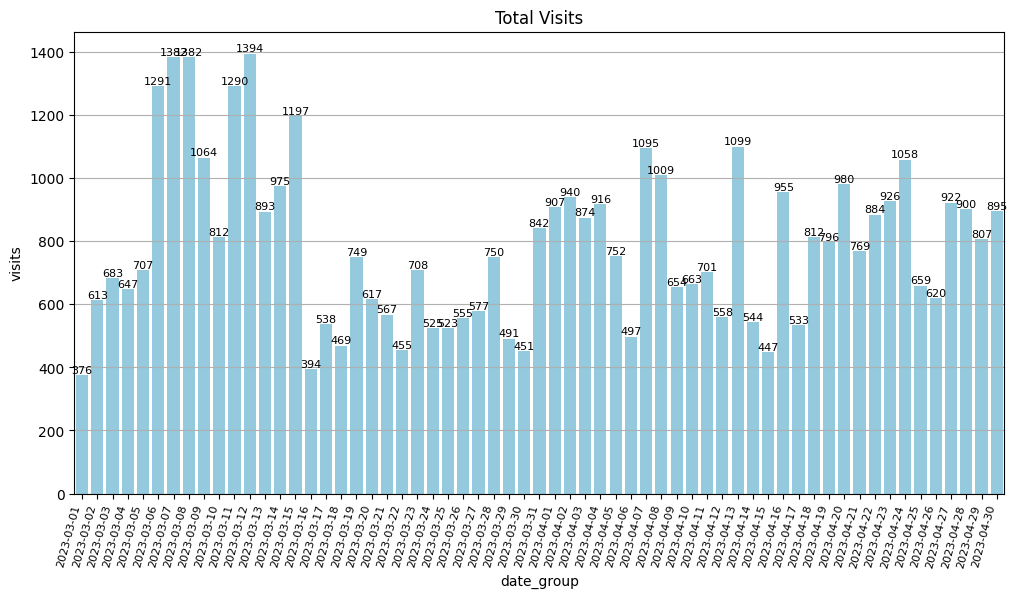

In [ ]:
# 1. Итоговые визиты
visits_total = final_conversion_df.groupby('date_group')['visits'].sum().reset_index()
plt.figure(figsize=(12,6))
ax = sns.barplot(data=visits_total, x='date_group', y='visits', color='skyblue')
ax.grid(axis='y')
ax.set_xticks(visits_total['date_group'])
ax.bar_label(ax.containers[0], fontsize=8)
plt.title('Total Visits')
plt.xlabel('date_group')
plt.ylabel('visits')
plt.xticks(rotation=75, ha='right', fontsize=8)
plt.savefig('./charts/visit.png')
plt.show()


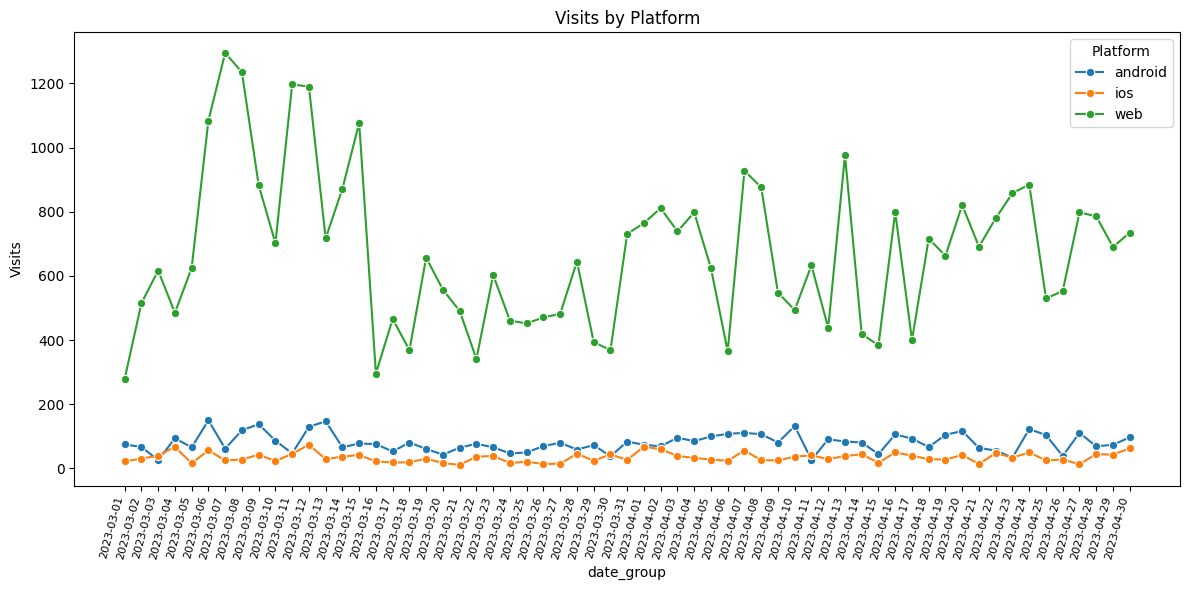

In [ ]:
# 2. Итоговые визиты с разбивкой по платформам
plt.figure(figsize=(12,6))
sns.lineplot(data=final_conversion_df, x='date_group', y='visits', hue='platform', marker='o')
plt.title('Visits by Platform')
plt.xlabel('date_group')
plt.ylabel('Visits')
plt.xticks(rotation=75, ha='right', fontsize=8)
plt.legend(title='Platform')
plt.tight_layout()
plt.savefig('./charts/visits_by_platform.png')
plt.show()


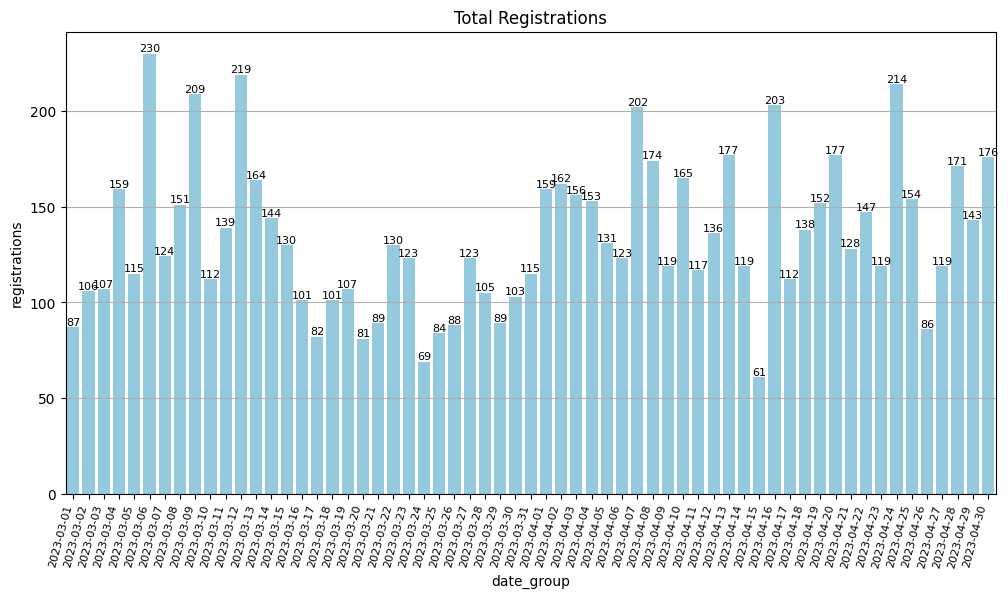

In [ ]:
# 3. Итоговые регистрации
visits_total = final_conversion_df.groupby('date_group')['registrations'].sum().reset_index()
plt.figure(figsize=(12,6))
ax = sns.barplot(data=visits_total, x='date_group', y='registrations', color='skyblue')
ax.grid(axis='y')
ax.set_xticks(visits_total['date_group'])
ax.bar_label(ax.containers[0], fontsize=8)
plt.title('Total Registrations')
plt.xlabel('date_group')
plt.ylabel('registrations')
plt.xticks(rotation=75, ha='right', fontsize=8)
plt.savefig('./charts/total_registrations.png')
plt.show()

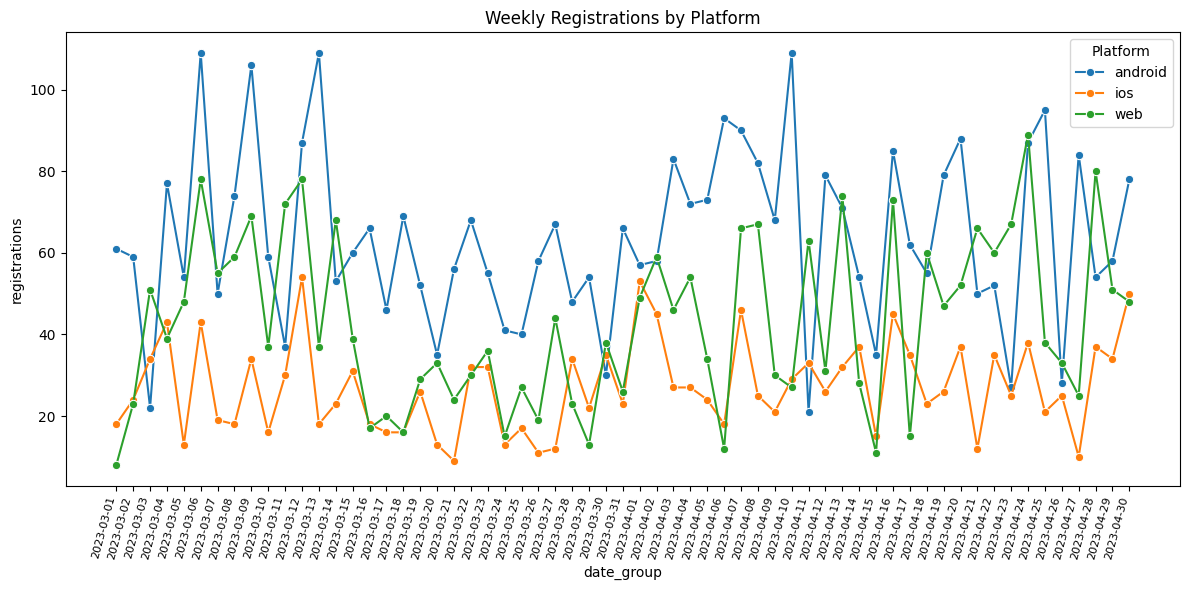

In [ ]:
# 4. Итоговые регистрации с разбивкой по платформе
plt.figure(figsize=(12,6))
sns.lineplot(data=final_conversion_df, x='date_group', y='registrations', hue='platform', marker='o')
plt.title('Weekly Registrations by Platform')
plt.xlabel('date_group')
plt.ylabel('registrations')
plt.xticks(rotation=75, ha='right', fontsize=8)
plt.legend(title='Platform')
plt.tight_layout()
plt.savefig('./charts/registrations_by_platform.png')
plt.show()

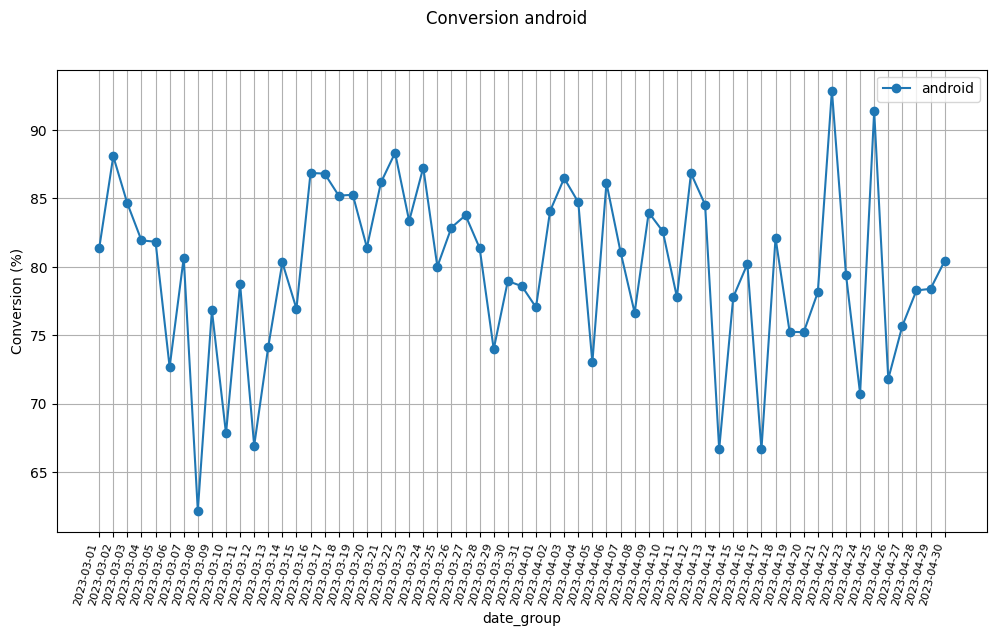

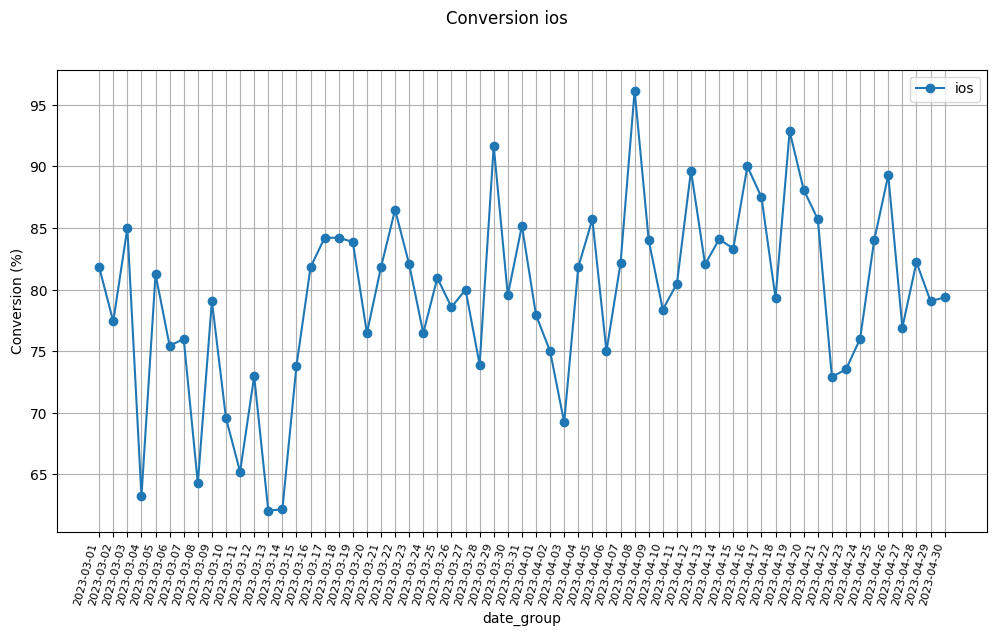

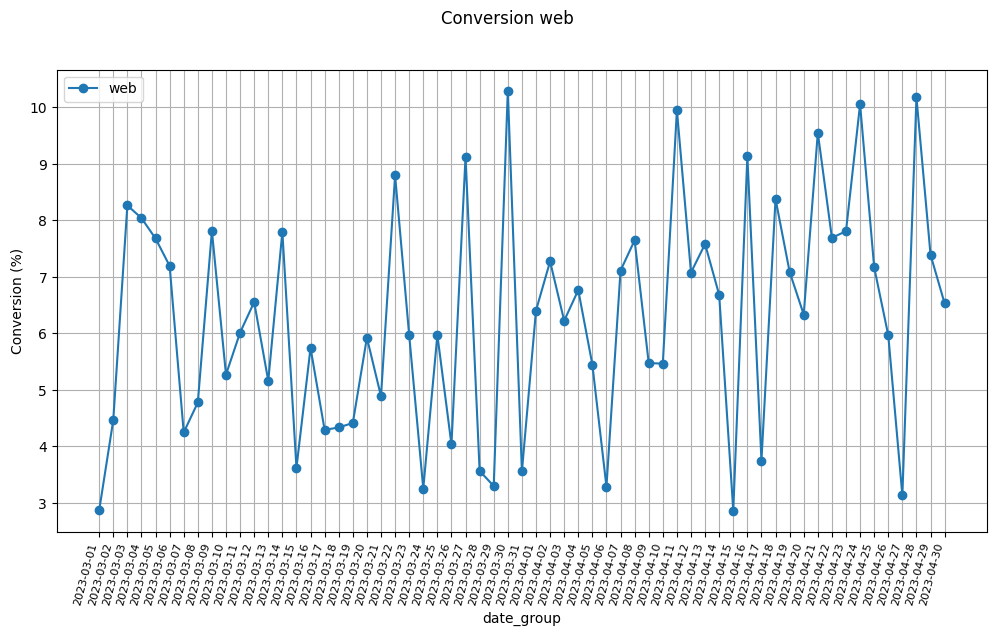

In [ ]:
# 5. Конверсия по каждой платформе
# andriod
conversion_df_android = final_conversion_df.loc[conversion_df['platform'] == 'android']
fig, ax = plt.subplots()
fig.set_size_inches((12, 6))
fig.suptitle("Conversion android")
x = conversion_df_android['date_group']
y = conversion_df_android['conversion']
ax.plot(x, y, data=conversion_df_android, marker='o', label='android')
plt.grid()
plt.xlabel('date_group')
plt.ylabel('Conversion (%)')
plt.xticks(rotation=75, ha='right', fontsize=8)
plt.legend()
plt.savefig('./charts/conversion_android.png')
plt.show()

# iOS
conversion_df_ios = final_conversion_df.loc[conversion_df['platform'] == 'ios']
fig, ax = plt.subplots()
fig.set_size_inches((12, 6))
fig.suptitle("Conversion ios")
x = conversion_df_ios['date_group']
y = conversion_df_ios['conversion']
ax.plot(x, y, data=conversion_df_ios, marker='o', label='ios')
plt.grid()
plt.xlabel('date_group')
plt.ylabel('Conversion (%)')
plt.xticks(rotation=75, ha='right', fontsize=8)
plt.legend()
plt.savefig('./charts/conversion_ios.png')
plt.show()

# Web
conversion_df_web = final_conversion_df.loc[conversion_df['platform'] == 'web']
fig, ax = plt.subplots()
fig.set_size_inches((12, 6))
fig.suptitle("Conversion web")
x = conversion_df_web['date_group']
y = conversion_df_web['conversion']
ax.plot(x, y, data=conversion_df_web, marker='o', label='web')
plt.grid()
plt.xlabel('date_group')
plt.ylabel('Conversion (%)')
plt.xticks(rotation=75, ha='right', fontsize=8)
plt.legend()
plt.savefig('./charts/conversion_web.png')
plt.show()

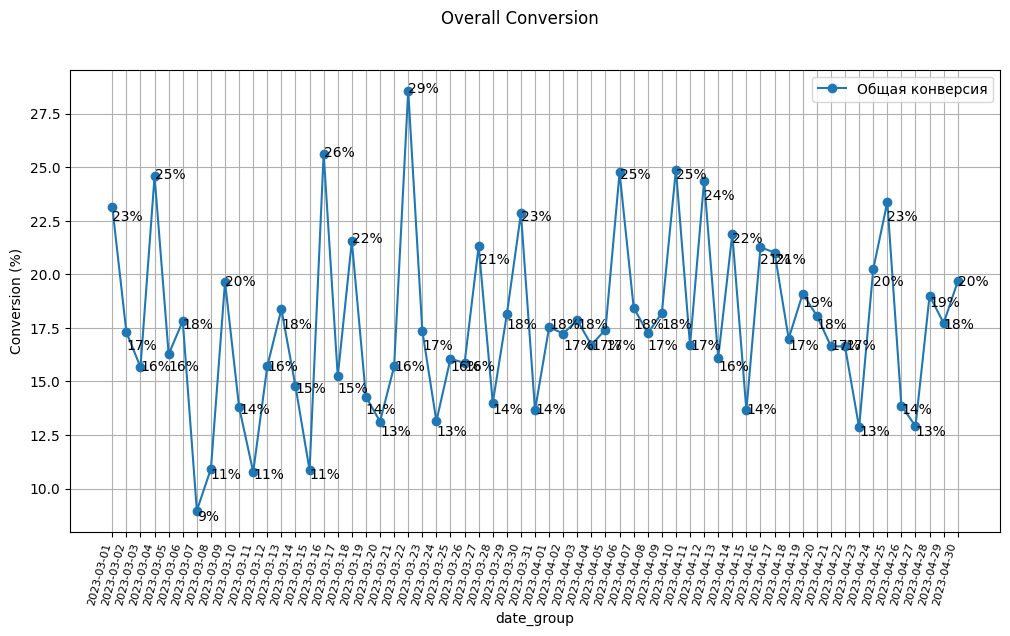

In [ ]:
# 6. Средняя конверсия
fig, ax = plt.subplots()
fig.set_size_inches((12, 6))
fig.suptitle("Overall Conversion")
x = total_conversion_df['date']
y = total_conversion_df['conversion']
ax.plot('date', 'conversion', data=total_conversion_df, marker='o', label='Общая конверсия')
plt.grid()
plt.xlabel('date_group')
plt.ylabel('Conversion (%)')
plt.xticks(rotation=75, ha='right', fontsize=8)
plt.legend()
for i, v in enumerate(y):
    ax.text(x[i], round(y[i]), str(round(v))+'%', fontsize=10, va='top')
plt.savefig('./charts/overall_conversion.png')
plt.show()


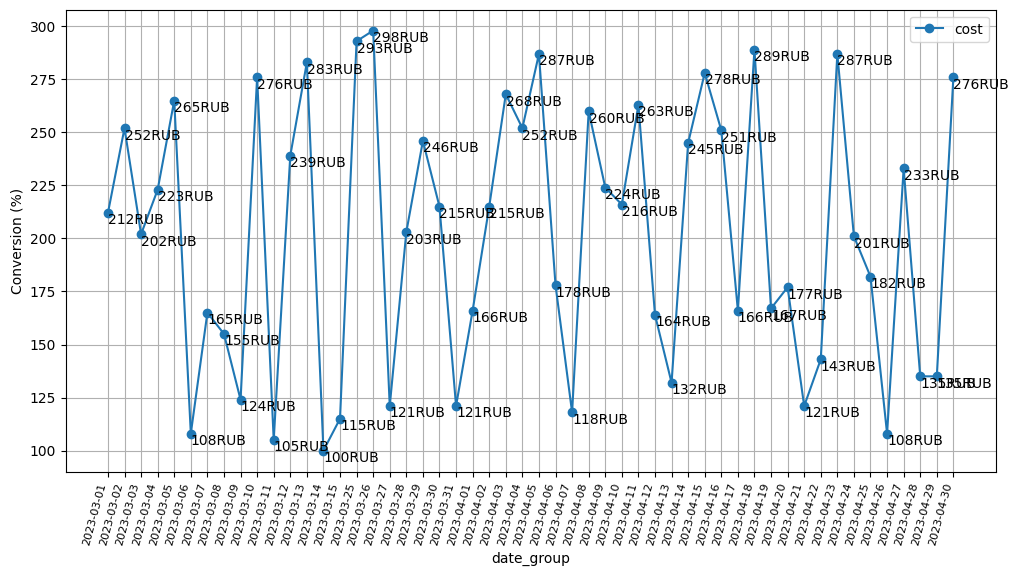

In [ ]:
# 7. Стоимости реклам

date_filter = prepared_ads_df['date_group'].between('2023-03-01', '2023-04-30')
prepared_ads_df = prepared_ads_df[date_filter]

fig, ax = plt.subplots()
fig.set_size_inches((12,6))
fig.suptitle("")
x = prepared_ads_df['date_group']
y = prepared_ads_df['cost']
ax.plot('date_group', 'cost', data=prepared_ads_df, marker='o', label='cost')
plt.grid()
plt.xlabel('date_group')
plt.ylabel('Conversion (%)')
plt.xticks(rotation=75, ha='right', fontsize=8)
plt.legend()
for i, v in enumerate(y):
    ax.text(x[i], round(y[i]), str(v)+'RUB', fontsize=10, va='top')
plt.savefig('./charts/agg_cost.png')
plt.show()


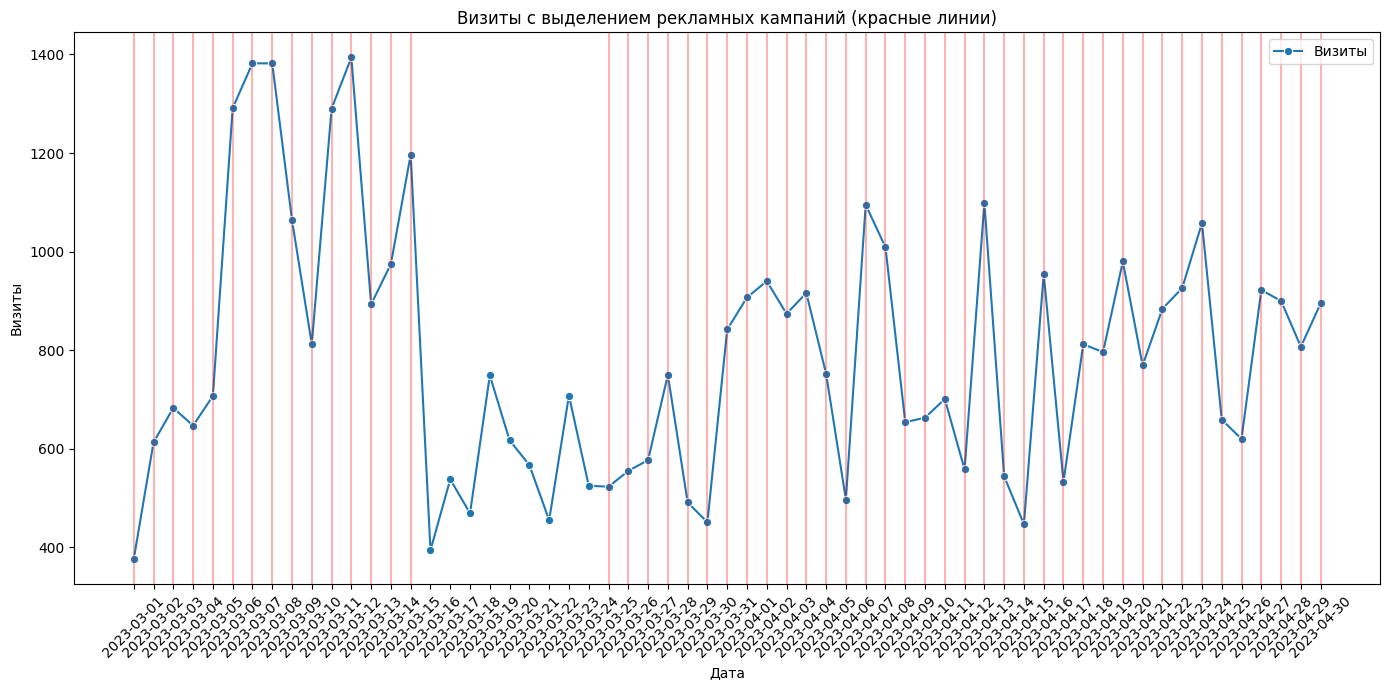

In [64]:
# 8. Визиты за весь период с цветовым выделением рекламной кампании

plt.figure(figsize=(14,7))
sns.lineplot(data=visits_total, x='date_group', y='visits', marker='o', label='Визиты')

# Добавим цветное выделение по наличию рекламы (cost > 0)
ad_days = prepared_ads_df[prepared_ads_df['cost'] > 0]['date_group']

for day in ad_days:
    plt.axvline(day, color='red', alpha=0.3)

plt.title('Визиты с выделением рекламных кампаний (красные линии)')
plt.xlabel('Дата')
plt.ylabel('Визиты')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./charts/visits_with_ads_highlight.png')
plt.show()